## <center> HR Analysis Using Logistic Regression 

* Introduction and Overview
> Embark on a captivating journey through human resources data, unveiling hidden insights. Each data point tells a unique story, revealing the delicate balance of employee experiences. From satisfaction and productivity to growth and collaboration, the dataset paints a vivid picture. Witness dedication and resilience through projects and average monthly hours. Experience the evolution of loyalty and wisdom over time. Reflect on safety, retention, recognition, and the vibrant interplay of departments. Appreciate the spectrum of salaries as symbols of reward. Unravel the secrets within, guiding us towards a future where data-driven strategies and human well-being intertwine, fostering success and fulfillment.

## Table of Contents

- [Import Libraries](#Libraries)
- [Input Scrollable Function](#Scrolling)
- [Data Loading and Preprocessing](#Data)
- [Exploratory Data Analysis (EDA)](#Analysis)
- [Feature Engineering](#Engineering)
- [Model Building](#Model)
- [Model Evaluation](#Evaluation)
- [Model Interpretation and Explainability](#Interpreation)

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
%matplotlib inline
from IPython.display import display, HTML

## 2. Input Scrolling Function

In [2]:
# Function to create scrollable table within a small window
def create_scrollable_table(df, table_id, title):
    html = f'<h3>{title}</h3>'
    html += f'<div id="{table_id}" style="height:200px; overflow:auto;">'
    html += df.to_html()
    html += '</div>'
    return html


## 3. Data Loading and Preprocessing

In [3]:
#Load The Dataset
df = pd.read_csv('/kaggle/input/hr-analytics/HR_comma_sep.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
numerical_features = df.select_dtypes(include=[np.number])
summary_stats = numerical_features.describe().T
html_numerical = create_scrollable_table(summary_stats, 'numerical_features','Summary statistics for numerical features')

display(HTML(html_numerical))

,count,mean,std,min,25%,50%,75%,max
satisfaction_level,14999.0,0.612834,0.248631,0.09,0.44,0.64,0.82,1.0
last_evaluation,14999.0,0.716102,0.171169,0.36,0.56,0.72,0.87,1.0
number_project,14999.0,3.803054,1.232592,2.00,3.00,4.00,5.00,7.0
average_montly_hours,14999.0,201.050337,49.943099,96.00,156.00,200.00,245.00,310.0
time_spend_company,14999.0,3.498233,1.460136,2.00,3.00,3.00,4.00,10.0
Work_accident,14999.0,0.144610,0.351719,0.00,0.00,0.00,0.00,1.0
left,14999.0,0.238083,0.425924,0.00,0.00,0.00,0.00,1.0
promotion_last_5years,14999.0,0.021268,0.144281,0.00,0.00,0.00,0.00,1.0


In [5]:
# Null values in the dataset
null_values = df.isnull().sum()
html_null_values = create_scrollable_table(null_values.to_frame(), 'null_values', 'Null values in the dataset')

# Percentage of missing values for each feature
missing_percentage = (df.isnull().sum() / len(df)) * 100
html_missing_percentage = create_scrollable_table(missing_percentage.to_frame(), 'missing_percentage', 'Percentage of missing values for each feature')

display(HTML(html_null_values + html_missing_percentage))

,0
satisfaction_level,0
last_evaluation,0
number_project,0
average_montly_hours,0
time_spend_company,0
Work_accident,0
left,0
promotion_last_5years,0
Department,0
salary,0


* **Based on what we can see, we can conclude that this Dataset does not contaion any missing Data**

In [6]:
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

## 4. Exploratory Data Analysis (EDA)

Text(0.5, 1.0, 'Satisfaction Level vs. Employee Retention')

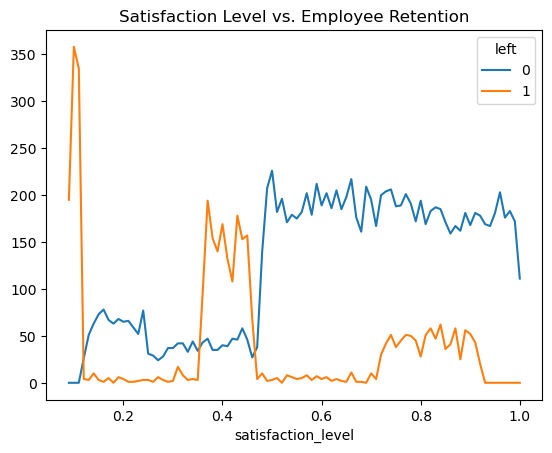

In [7]:
pd.crosstab(df.satisfaction_level,df.left).plot(kind = 'line')
plt.title('Satisfaction Level vs. Employee Retention')

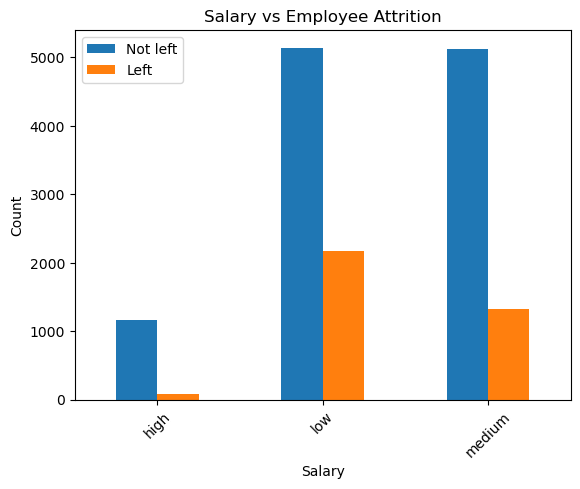

In [8]:
new_df = df['salary']
rep = new_df.replace(['low', 'medium', 'high'], [1, 2, 3])
crosstab_data = pd.crosstab(new_df, df['left'])
ax = crosstab_data.plot(kind='bar')

ax.legend(['Not left', 'Left'])

plt.xlabel('Salary')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Salary vs Employee Attrition')

plt.show()


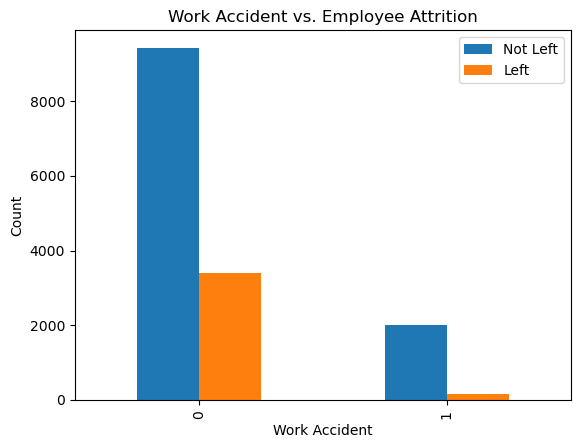

In [9]:
crosstab_data = pd.crosstab(df.Work_accident, df.left)
ax = crosstab_data.plot(kind='bar')


ax.legend(['Not Left', 'Left'])


plt.xlabel('Work Accident')
plt.ylabel('Count')
plt.title('Work Accident vs. Employee Attrition')


plt.show()


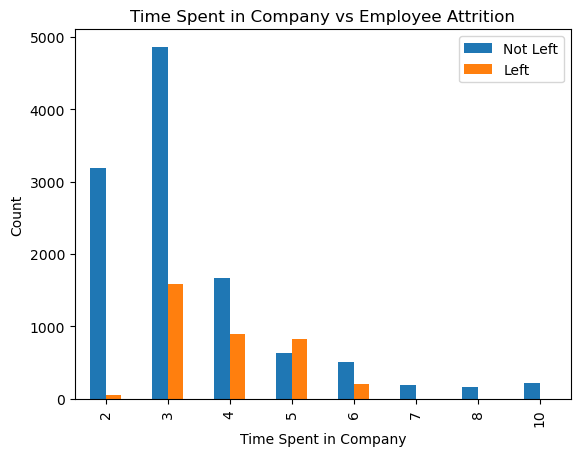

In [10]:
crosstab_data = pd.crosstab(df.time_spend_company, df.left)
ax = crosstab_data.plot(kind = 'bar')

ax.legend(['Not Left','Left'])

plt.title('Time Spent in Company vs Employee Attrition')
plt.xlabel('Time Spent in Company')
plt.ylabel('Count')

plt.show()

* **We can conclude that those who spent the most time at work didn't leave**

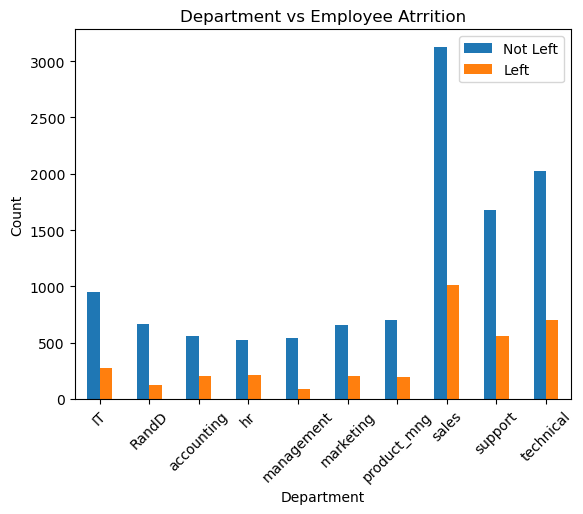

In [11]:
crosstab_data = pd.crosstab(df.Department, df.left)
ax = crosstab_data.plot(kind='bar')

ax.legend(['Not Left', 'Left'])

plt.title('Department vs Employee Atrrition')
plt.xticks(rotation =45)
plt.xlabel('Department')
plt.ylabel('Count')

plt.show()

* **We can conclude that most people who left their job were in the Sales Department**

/tmp/ipykernel_20/1307701243.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_matrix = df.corr()


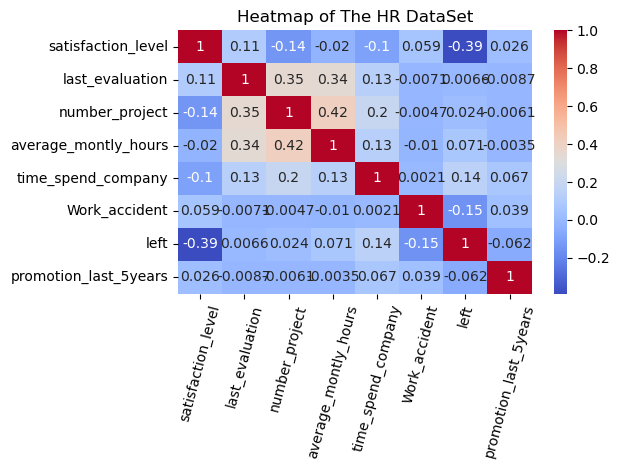

In [12]:
data_matrix = df.corr()  


sns.heatmap(data_matrix, cmap='coolwarm', annot=True)


plt.xticks(rotation = 75)
plt.yticks(rotation = 0)
plt.title('Heatmap of The HR DataSet')


plt.tight_layout()


plt.show()


## 5. Feature Engineering

* From the dataset we can conclude that the following are the independent variables:

1. **Satisfaction level**
2. **Average montly hours**
3. **Time spend company**
4. **Promotion last 5years**
5. **Salary**

In [13]:
subdf = df[['satisfaction_level','average_montly_hours','time_spend_company','promotion_last_5years','salary']]
subdf.head()

,satisfaction_level,average_montly_hours,time_spend_company,promotion_last_5years,salary
0,0.38,157,3,0,low
1,0.80,262,6,0,medium
2,0.11,272,4,0,medium
3,0.72,223,5,0,low
4,0.37,159,3,0,low


* Since salaries include words such as high, low and medium will use dummy variables for it.

In [14]:
salary_dummies = pd.get_dummies(subdf.salary, prefix="salary" )
df_with_dummies = pd.concat([subdf,salary_dummies], axis='columns')
df_with_dummies.head()

,satisfaction_level,average_montly_hours,time_spend_company,promotion_last_5years,salary,salary_high,salary_low,salary_medium
0,0.38,157,3,0,low,0,1,0
1,0.80,262,6,0,medium,0,0,1
2,0.11,272,4,0,medium,0,0,1
3,0.72,223,5,0,low,0,1,0
4,0.37,159,3,0,low,0,1,0


In [15]:
df_with_dummies.drop('salary',axis='columns',inplace=True)
df_with_dummies.head()

,satisfaction_level,average_montly_hours,time_spend_company,promotion_last_5years,salary_high,salary_low,salary_medium
0,0.38,157,3,0,0,1,0
1,0.80,262,6,0,0,0,1
2,0.11,272,4,0,0,0,1
3,0.72,223,5,0,0,1,0
4,0.37,159,3,0,0,1,0


In [16]:
X = df_with_dummies
X.head()

,satisfaction_level,average_montly_hours,time_spend_company,promotion_last_5years,salary_high,salary_low,salary_medium
0,0.38,157,3,0,0,1,0
1,0.80,262,6,0,0,0,1
2,0.11,272,4,0,0,0,1
3,0.72,223,5,0,0,1,0
4,0.37,159,3,0,0,1,0


In [17]:
y = df.left
y.head()

0    1
1    1
2    1
3    1
4    1
Name: left, dtype: int64

## 6. Model Building

We are going to use Train Test Split Model, because our dataset does not contain a train file. So using Train test split will enable us to test and train the data set

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y , train_size= 0.4)

In [19]:
model = LogisticRegression()

In [20]:
model.fit(X_train,y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [21]:
model.predict(X_test)

array([0, 0, 1, ..., 0, 0, 0])

## 7. Model Evaluation

* **Accuracy Of The Model**

In [22]:
model.score(X_test,y_test)

0.7692222222222223